In [1]:
!pip install --quiet -U gensim

     |████████████████████████████████| 24.1 MB 1.2 MB/s 


In [2]:
!pip install --quiet transformers

     |████████████████████████████████| 4.7 MB 30.8 MB/s 
     |████████████████████████████████| 6.6 MB 55.1 MB/s 
     |████████████████████████████████| 120 kB 91.6 MB/s 


In [3]:
!pip3 install --quiet keras

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/AML/HW4/classifier

/content/drive/MyDrive/AML/HW4/classifier


In [6]:
!ls

 BERT-classification-on-text-augmented.ipynb
 BERT-classification-on-text.ipynb
 BERT-pretrained-features.ipynb
 classification_test_results.tsv
 dreaddit
 dreaddit-test.csv
 dreaddit-train.csv
 dreddit.ipynb
 GoogleNews-vectors-negative300.bin
 GoogleNews-vectors-negative300.bin.gz
 logs
 pre-trained-BERT-features-2.ipynb
 results
 tBERT_LDA_augmented_dreddit.ipynb
 tBERT_with_LDA_for_dreddit.ipynb
 test_data.tsv
 tfi-df-embeddings.ipynb
 train_data_for_students.tsv
 trump_tweets_classifiers.ipynb
'w2v_domain_trained_ GSDMM.ipynb'
 w2v-domain-trained.ipynb
 w2v_domain_trained_lda_augmented_self_training.ipynb
 w2v-domain-trained-lda.ipynb
 w2v_domain_trained_LDA_multilabled.ipynb
 w2v-google-news-pretrained.ipynb


In [7]:
!spacy download en
# !spacy download zh
!spacy download en_core_web_sm ## pretrained word vectors

2022-09-04 19:51:19.231501: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 16.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2022-09-04 19:51:33.920754: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.4.0/en_core_web_sm-3.4.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now

In [8]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 32.6 MB/s 


In [9]:
# Data processing
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

import transformers
import torch
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available

# Visualization
from matplotlib import pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import LabelEncoder

# Text processing
import re
import nltk
import gensim.downloader as api

# Various
from datetime import datetime
#Google Drive
from google.colab import drive

import re
import tqdm

import gensim, logging, spacy
from spacy import displacy

from sklearn.manifold import MDS
from sklearn.manifold import TSNE

In [10]:
import nlpaug.augmenter.word as naw

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Init Data

In [12]:
# load language model
nlp_en = spacy.load('en_core_web_sm', disable=["parser"])

In [13]:
SEED = 82

In [14]:
def set_seed(seed: int):
    # numpy
    np.random.seed(seed)

    # torch
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
         
set_seed(SEED)

In [15]:
def concat_two(original, new_x, features_from_original):
  # print(f'concat_two original - {original[features_from_original].shape}')
  # print(f'concat_two new_x - {new_x.shape}')
  new_df = pd.concat([new_x, original[features_from_original]], axis=1, ignore_index=True)
  # print(f'concat_two - {new_df.shape}')
  return new_df

In [16]:
def get_domain(subreddit):
  if subreddit=='domesticviolence' or subreddit=='survivorsofabuse':
    return 'abuse';
  if subreddit=='anxiety' or subreddit=='stress':
    return 'anxiety';
  if subreddit=='almosthomeless' or subreddit=='assistance' or subreddit=='food_pantry' or subreddit=='homeless':
    return 'financial';
  if subreddit=='ptsd':
    return 'ptsd';
  else:
    return 'social';

In [17]:
train = pd.read_csv('dreaddit/dreaddit-train.csv')
test = pd.read_csv('dreaddit/dreaddit-test.csv')

main_df = pd.concat([train, test], axis=0)
main_df = main_df.reset_index()
main_df.shape

(3553, 117)

In [18]:
X_train = main_df.copy(deep=True)

In [19]:
X_test = X_train[X_train['confidence'] >= 0.8].sample(n=715, random_state=SEED)
x_test_indexes = list(X_test.index)
X_test = X_test.copy(deep=True)
X_test.shape

(715, 117)

In [20]:
X_train = X_train.drop(labels=x_test_indexes, axis=0, inplace = False)
X_train.shape

(2838, 117)

In [21]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()

In [22]:
train_for_vocabulary = X_train[X_train['confidence'] >= 0.8]

In [23]:
X_train['text_clean'] = X_train['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

In [24]:
X_train_clean = X_train['text_clean']

In [25]:
X_test['text_clean'] = X_test['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

In [26]:
X_test_clean = X_test['text_clean']

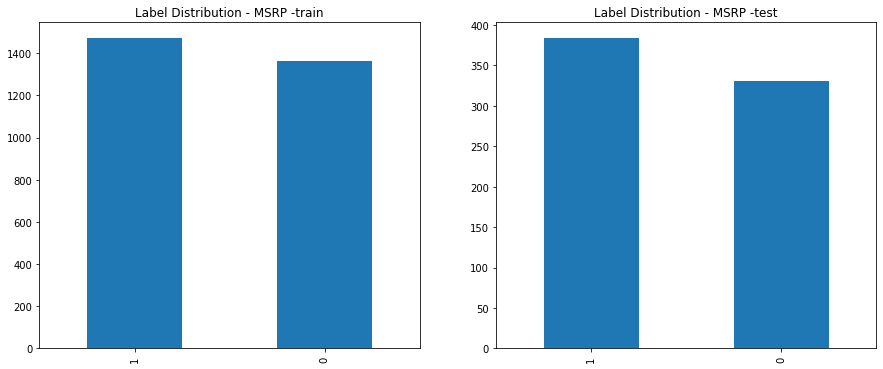

In [27]:
d = {'train':X_train,'test':X_test}

plt.figure(figsize=(15,6))

for i,(k,v) in enumerate(d.items()):
  plt.subplot(1,2,i+1)
  v.label.value_counts().plot.bar();
  plt.title('Label Distribution - MSRP -' + k)

## Data Augmentation

In [28]:
import itertools
aug = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)
augmented_texts_positive = [aug.augment(s, n=4) for s in train_for_vocabulary[train_for_vocabulary['label']==1].text.tolist()]
augmented_texts_positive = list(itertools.chain.from_iterable(augmented_texts_positive))
augmented_text_negative = [aug.augment(s, n=5) for s in train_for_vocabulary[train_for_vocabulary['label']==0].text.tolist()]
augmented_text_negative = list(itertools.chain.from_iterable(augmented_text_negative))
for_w2v_training = []
for_w2v_training.extend(augmented_texts_positive)
for_w2v_training.extend(augmented_text_negative)
for_w2v_training = [gensim.utils.simple_preprocess(s) for s in for_w2v_training]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Word2Vec prepare

In [29]:
expected_vector_size=300

In [30]:
w2v_model = gensim.models.Word2Vec(for_w2v_training,
                                   vector_size=expected_vector_size,
                                   window=5,
                                   min_count=2)

In [31]:
len(set(w2v_model.wv.index_to_key ))

10376

In [32]:
w2v_model.wv.most_similar('stress')

[('posttraumatic', 0.9548575282096863),
 ('depression', 0.9436898827552795),
 ('disorder', 0.9391273260116577),
 ('anxiousness', 0.9215139746665955),
 ('setting', 0.9108293056488037),
 ('severe', 0.904495120048523),
 ('mild', 0.9019730687141418),
 ('generalized', 0.9012013077735901),
 ('military', 0.8985821604728699),
 ('chronic', 0.8981095552444458)]

In [33]:
words = set(w2v_model.wv.index_to_key )

X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train_clean])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test_clean])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [34]:
X_train_vect_avg = []
no_v_size = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        # print('no v.size')
        no_v_size.append(v)
        X_train_vect_avg.append(np.zeros(expected_vector_size, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        # print('no v.size in test')
        no_v_size.append(v)
        X_test_vect_avg.append(np.zeros(expected_vector_size, dtype=float))
print(f'no v size detected {len(no_v_size)}')

no v size detected 0


## LDA

In [35]:
nlp = spacy.load("en_core_web_sm")

# Load NLTK stopwords
stop_words = stopwords.words('english')
# Add some extra words in it if required
stop_words.extend(['from', 'subject', 'use','pron'])

In [36]:
def clean_proc(sentences):
  # Convert to list 
  data = sentences 
  # Remove Emails 
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]  
  # Remove new line characters 
  data = [re.sub('\s+', ' ', sent) for sent in data]  
  # Remove distracting single quotes 
  data = [re.sub("\'", "", sent) for sent in data]  
  data = [re.sub("'", "", sent) for sent in data]
  data = [re.sub("\r", "", sent) for sent in data]
  data = [re.sub("[,\.!?]", "", sent) for sent in data]
  def sent_to_words(sentences):
    for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
  data_words = list(sent_to_words(data))

  print(f'sen_to_words:\n{data_words[:1]}')
  # Build the bigram and trigram models
  bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
  trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
  # Faster way to get a sentence clubbed as a trigram/bigram
  bigram_mod = gensim.models.phrases.Phraser(bigram)
  trigram_mod = gensim.models.phrases.Phraser(trigram)
  # See trigram example
  print(f'trigrams :\n{trigram_mod[bigram_mod[data_words[0]]]}')
  # Define function for stopwords, bigrams, trigrams and lemmatization
  def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

  def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

  def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

  def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp_en(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

  # Remove Stop Words
  data_words_nostops = remove_stopwords(data_words)

  # Form Bigrams
  data_words_grams = make_bigrams(data_words_nostops)

  # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
  # python3 -m spacy download en
  # nlp = spacy.load('en', disable=['parser', 'ner'])

  # Do lemmatization keeping only noun, adj, vb, adv
  data_lemmatized = lemmatization(data_words_grams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
  # data_lemmatized = data_words_3grams

  print(f'after lemmatization: \n{data_lemmatized[:1]}')
  return data_lemmatized

In [37]:
# train_sentences_for_lda_model_training = df[(df['confidence'] >= 0.8) & (df['label'] == 1)].text.values.tolist()
# train_sentences_for_lda_model_training = df[(df['confidence'] >= 0.8) & (df['label'] == 1)].text.values.tolist()
train_sentences_for_lda_model_training = augmented_texts_positive
data_words_clean_for_lda_model_training = clean_proc(train_sentences_for_lda_model_training)

sen_to_words:
[['he', 'said', 'atomic', 'number', 'had', 'not', 'felt', 'that', 'way', 'before', 'suggeted', 'go', 'rest', 'and', 'so', 'trigger', 'ahead', 'if', 'youi', 're', 'ampere', 'hypocondriac', 'like', 'me', 'decide', 'to', 'look', 'up', 'feelings', 'of', 'doom', 'in', 'hopes', 'of', 'maybe', 'amaze', 'sucked', 'into', 'some', 'rabbit', 'hole', 'of', 'ludicrous', 'conspiracy', 'stupid', 'are', 'you', 'psychical', 'test', 'or', 'new', 'years', 'something', 'could', 'even', 'laugh', 'at', 'down', 'the', 'road', 'no', 'one', 'ended', 'up', 'reading', 'that', 'this', 'sense', 'of', 'doom', 'can', 'be', 'indicative', 'of', 'various', 'health', 'ailments', 'one', 'of', 'which', 'am', 'prone', 'to', 'so', 'on', 'top', 'of', 'my', 'doom', 'to', 'my', 'gloom', 'am', 'now', 'worried', 'about', 'my', 'heart', 'do', 'happen', 'to', 'have', 'physical', 'in', 'hours']]
trigrams :
['he', 'said', 'atomic_number', 'had', 'not', 'felt', 'that', 'way', 'before', 'suggeted', 'go', 'rest', 'and', '

In [38]:
# train_sentences_for_lda_model_training_neg_label = df[(df['confidence'] >= 0.8) & (df['label'] == 0)].text.values.tolist()
data_words_clean_for_lda_model_training_neg_label = augmented_text_negative
data_words_clean_for_lda_model_training_neg_label  = clean_proc(data_words_clean_for_lda_model_training_neg_label)

sen_to_words:
[['hey', 'there', 'assistance', 'not', 'indisputable', 'if', 'this', 'is', 'the', 'right', 'space', 'to', 'post', 'this', 'but', 'here', 'goes', 'currently', 'student', 'intern', 'at', 'sandia', 'subject', 'labs', 'and', 'working', 'on', 'survey', 'to', 'help', 'improve', 'our', 'marketing', 'outreach', 'efforts', 'at', 'the', 'many', 'schools', 'we', 'inscribe', 'at', 'around', 'the', 'country', 'we', 're', 'looking', 'for', 'current', 'undergrad', 'grad', 'stem', 'students', 'so', 'if', 'you', 're', 'stem', 'student', 'or', 'know', 'stem', 'students', 'would', 'greatly', 'value', 'if', 'you', 'can', 'help', 'take', 'or', 'pass', 'along', 'this', 'unretentive', 'survey', 'as', 'thank', 'you', 'everyone', 'world', 'health', 'organization', 'helps', 'take', 'the', 'survey', 'testament', 'personify', 'entered', 'in', 'to', 'drawing', 'for', 'chance', 'to', 'win', 'one', 'of', 'three', 'amazon', 'gcs']]
trigrams :
['hey', 'there', 'assistance', 'not', 'indisputable', 'if', '

In [39]:
train_sentences = X_train.text.values.tolist()
data_words_clean_for_train = clean_proc(train_sentences)

sen_to_words:
[['he', 'said', 'he', 'had', 'not', 'felt', 'that', 'way', 'before', 'suggeted', 'go', 'rest', 'and', 'so', 'trigger', 'ahead', 'if', 'youire', 'hypocondriac', 'like', 'me', 'decide', 'to', 'look', 'up', 'feelings', 'of', 'doom', 'in', 'hopes', 'of', 'maybe', 'getting', 'sucked', 'into', 'some', 'rabbit', 'hole', 'of', 'ludicrous', 'conspiracy', 'stupid', 'are', 'you', 'psychic', 'test', 'or', 'new', 'age', 'bs', 'something', 'could', 'even', 'laugh', 'at', 'down', 'the', 'road', 'no', 'ended', 'up', 'reading', 'that', 'this', 'sense', 'of', 'doom', 'can', 'be', 'indicative', 'of', 'various', 'health', 'ailments', 'one', 'of', 'which', 'am', 'prone', 'to', 'so', 'on', 'top', 'of', 'my', 'doom', 'to', 'my', 'gloomi', 'am', 'now', 'fn', 'worried', 'about', 'my', 'heart', 'do', 'happen', 'to', 'have', 'physical', 'in', 'hours']]
trigrams :
['he', 'said', 'he', 'had', 'not', 'felt', 'that', 'way', 'before', 'suggeted', 'go', 'rest', 'and', 'so', 'trigger', 'ahead', 'if', 'you

In [40]:
mapped_for_train = dict()
for i, words in enumerate(data_words_clean_for_train):
  mapped_for_train[train_sentences[i]] = words

In [41]:
test_sentences = X_test.text.values.tolist()
data_words_clean_for_test = clean_proc(test_sentences)

sen_to_words:
[['im', 'new', 'to', 'this', 'so', 'please', 'forgive', 'me', 'im', 'not', 'very', 'good', 'at', 'expressing', 'my', 'emotions', 'need', 'advice', 'help', 'was', 'molested', 'multiple', 'times', 'by', 'my', 'biological', 'dad', 'when', 'was', 'up', 'until', 'middle', 'school', 'so', 'like', 'yrs', 'old', 'after', 'many', 'times', 'in', 'the', 'past', 'telling', 'my', 'mom', 'that', 'my', 'dad', 'had', 'touched', 'me', 'weird', 'my', 'mom', 'had', 'gotten', 'annoyed', 'and', 'mad', 'at', 'me']]
trigrams :
['im', 'new', 'to', 'this', 'so', 'please', 'forgive', 'me', 'im', 'not', 'very', 'good', 'at', 'expressing', 'my', 'emotions', 'need', 'advice', 'help', 'was', 'molested', 'multiple', 'times', 'by', 'my', 'biological', 'dad', 'when', 'was', 'up', 'until', 'middle', 'school', 'so', 'like', 'yrs', 'old', 'after', 'many', 'times', 'in', 'the', 'past', 'telling', 'my', 'mom', 'that', 'my', 'dad', 'had', 'touched', 'me', 'weird', 'my', 'mom', 'had', 'gotten', 'annoyed', 'and'

In [42]:
mapped_for_test = dict()
for i, words in enumerate(data_words_clean_for_test):
  mapped_for_test[test_sentences[i]] = words

In [43]:
import gensim.corpora as corpora
# Create Dictionary
dictionary = corpora.Dictionary(data_words_clean_for_lda_model_training)
# Print dictionary
print(dictionary.token2id)

## Create Term document frequency (corpus)
# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in data_words_clean_for_lda_model_training]

{'ahead': 0, 'ailment': 1, 'amaze': 2, 'ampere': 3, 'conspiracy': 4, 'decide': 5, 'doom': 6, 'end': 7, 'even': 8, 'feel': 9, 'feeling': 10, 'gloom': 11, 'go': 12, 'happen': 13, 'health': 14, 'heart': 15, 'hope': 16, 'hour': 17, 'hypocondriac': 18, 'indicative': 19, 'laugh': 20, 'look': 21, 'ludicrous': 22, 'maybe': 23, 'new': 24, 'physical': 25, 'prone': 26, 'psychical': 27, 'rabbit_hole': 28, 'read': 29, 'rest': 30, 'road': 31, 'say': 32, 'sense': 33, 'stupid': 34, 'suck': 35, 'suggete': 36, 'test': 37, 'top': 38, 'trigger': 39, 'various': 40, 'way': 41, 'worry': 42, 'year': 43, 'age': 44, 'ane': 45, 'coney': 46, 'get': 47, 'hole': 48, 'perhaps': 49, 'psychic': 50, 'significative': 51, 'single': 52, 'state': 53, 'youi': 54, 'bear': 55, 'examination': 56, 'experience': 57, 'hold': 58, 'mother': 59, 'strong_arm': 60, 'express': 61, 'indicatory': 62, 'iodine': 63, 'mirth': 64, 'address': 65, 'answer': 66, 'ask': 67, 'attention': 68, 'backseat': 69, 'car': 70, 'collision': 71, 'drive': 72

In [44]:
mapped_for_test[test_sentences[-1]]

['maybe',
 'afraid',
 'good',
 'word',
 'far',
 'm',
 'worried',
 'physically',
 'harm',
 'even',
 'hate',
 'kid',
 'kid',
 'actually',
 'certain',
 'kid',
 'uncle',
 'girlfriend',
 'kid',
 'make',
 'uncomfortable',
 'make',
 'anxiety',
 'go',
 'badly',
 's',
 'disrespectful',
 'harasse',
 'm',
 'around',
 'hell',
 'make',
 'smart',
 'ass',
 'remark',
 'typical',
 'small',
 'child',
 'insult',
 'get',
 'hurt',
 'feeling',
 'much',
 'get',
 'm',
 'pathetic',
 'even',
 'demand',
 'respect',
 'fucking',
 'child',
 'today',
 'play',
 'backyard',
 'brother',
 'respectful',
 'love',
 'ask',
 'peg',
 'ball',
 'groin',
 'obviously',
 'say']

In [45]:
test_sentences[-1]

"Well maybe afraid isn't the best word, but it's not far off. I'm not worried they can physically harm me or anything, nor do I even hate kids, most kids I actually like, but certain kids, like uncle's girlfriend's one kids, make me uncomfortable and make my anxiety go off badly. He's like 6 or something like that, but he is disrespectful to me, and harasses me when I'm around. He'll make smart ass remarks which although typical small child insults, get to me, not because they hurt my feelings so much, but it gets to me that I'm so pathetic, I can't even demand respect from a fucking child. Today, playing some backyard cricket with my brother and other cousin (a very respectful kid who I love), he asks if he can peg the ball at my groin, to which I obviously say no, so what does he do?"

In [47]:
class LDA_Wrapper_Topics_Distributions_Gensim:
    def __init__(self, random_seed, data_words_clean, map_for_train, corpus, dictionary, alpha=0.01, eta=0.91, n_components=10):
      self.alpha = alpha
      self.eta = eta
      self.seed = random_seed
      self.map_for_train=map_for_train
      self.data_words_clean = data_words_clean
      self.corpus = corpus
      self.dictionary = dictionary
      self.n_components = n_components
      self.ldamodel = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=self.n_components, 
                                           passes=25,
                                           alpha=self.alpha,
                                           eta=self.eta,
                                           random_state=random_seed,
                                           minimum_probability = 0.00000001,
                                           eval_every = 1,
                                           per_word_topics=True)

      # Saving trained model
      self.ldamodel.save(f'results/LDA_{self.n_components}')
      # Loading trained model
      self.ldamodel = gensim.models.ldamulticore.LdaMulticore.load(f'results/LDA_{self.n_components}')
      self.max_len = n_components
      self.log_lines = []
      self.print=self.__print_log__

    def __print_log__(self, x):
      pass

    def topic_distribution_by_topic_order(self, string_input):
      # Fit and transform
      bow = self.ldamodel.id2word.doc2bow(string_input) # convert to bag of words format first

      doc_topics, word_topics, phi_values = self.ldamodel.get_document_topics(bow, per_word_topics=True)

      output = [topic[1] for topic in doc_topics]    
      return output

    def transform(self, sentences):
      p = []
      for sentence in sentences:
        clean_sentence = self.map_for_train[sentence]

        dists = self.topic_distribution_by_topic_order(clean_sentence)
        p.append(dists)

      self.print("in transform")
      return torch.tensor(p).type(torch.FloatTensor);

    def transform_to_words(self, sentences):
      p = []
      for sentence in sentences:
        clean_sentence = self.map_for_train[sentence]
        dists = self.topic_distribution_by_topic_order(clean_sentence)
        p.append(dists)
      max_indexes = np.argmax(p, axis = 1)
      words = []
      for index in max_indexes:
        topk = self.ldamodel.show_topic(index, 20)
        topk_words = [ w for w, _ in topk ]
        words.append(topk_words)
      return words

    def transform_cleaned_to_words(self, sentences):
      p = []
      for clean_sentence in sentences:
        dists = self.topic_distribution_by_topic_order(clean_sentence)
        p.append(dists)
      max_indexes = np.argmax(p, axis = 1)
      words = []
      for index in max_indexes:
        topk = self.ldamodel.show_topic(index, 20)
        topk_words = [ w for w, _ in topk ]
        words.append(topk_words)
      return words

    def transform_cleaned(self, sentences):
      p = []
      for clean_sentence in sentences:
        dists = self.topic_distribution_by_topic_order(clean_sentence)
        p.append(dists)
      self.print("in transform")
      return torch.tensor(p).type(torch.FloatTensor);

    def evaluate_model(self):
      # Compute Perplexity Score
      print('nPerplexity Score: ', self.ldamodel.log_perplexity(self.corpus))

      # Compute Coherence Score
      coherence_model_lda = gensim.models.CoherenceModel(model=self.ldamodel, texts=self.data_words_clean, dictionary=self.dictionary, coherence='c_v')
      coherence_lda = coherence_model_lda.get_coherence()
      return coherence_lda

In [48]:
# topics = [5,6,7, 8, 9, 10, 15, 20, 25, 30, 40, 75, 80, 85, 90, 100]
topics = [75, 80, 85, 90, 100]
alpha = 0.08
eta = 0.97

In [49]:
topics_dict_gensim = dict()
print(f'creating topic generators')
# n_topics
evaluation = []
for n in topics:
  set_seed(SEED)
  topics_dict_gensim[n] = LDA_Wrapper_Topics_Distributions_Gensim(SEED, data_words_clean_for_lda_model_training, mapped_for_train,
                                                                  corpus, dictionary, alpha=alpha, eta=eta, n_components=n)
  evaluated_coherence = topics_dict_gensim[n].evaluate_model()
  evaluation.append(evaluated_coherence)
  print(f'K={n} - Coherence Score: ', evaluated_coherence)
  print(f'created topic generator for {n} topics')

creating topic generators
nPerplexity Score:  -7.849504994481822
K=75 - Coherence Score:  0.4864275565789323
created topic generator for 75 topics
nPerplexity Score:  -7.87960032599371
K=80 - Coherence Score:  0.48324910107551916
created topic generator for 80 topics
nPerplexity Score:  -7.886657452385468
K=85 - Coherence Score:  0.4613707364308389
created topic generator for 85 topics
nPerplexity Score:  -7.908909744008121
K=90 - Coherence Score:  0.4869464968365348
created topic generator for 90 topics
nPerplexity Score:  -7.950297993742433
K=100 - Coherence Score:  0.5058757825122311
created topic generator for 100 topics


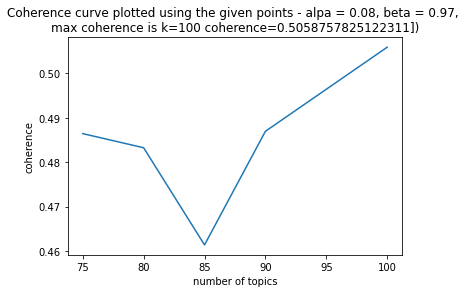

In [50]:
x = np.array(topics)
y = np.array(evaluation)
max_coerence_index = np.argmax(evaluation)
# Plotting the Graph
plt.plot(x, y)
plt.title(f"Coherence curve plotted using the given points - alpa = {alpha}, beta = {eta}, \nmax coherence is k={topics[max_coerence_index]} coherence={evaluation[max_coerence_index]}])")
plt.xlabel("number of topics")
plt.ylabel("coherence")
plt.show()

In [51]:
import gensim.corpora as corpora
# Create Dictionary
dictionary_neg_label = corpora.Dictionary(data_words_clean_for_lda_model_training_neg_label)
# Print dictionary
print(dictionary_neg_label.token2id)

## Create Term document frequency (corpus)
# Term Document Frequency
corpus_neg_label = [dictionary_neg_label.doc2bow(text) for text in data_words_clean_for_lda_model_training_neg_label]

{'assistance': 0, 'chance': 1, 'country': 2, 'current': 3, 'currently': 4, 'drawing': 5, 'effort': 6, 'enter': 7, 'go': 8, 'grad': 9, 'greatly': 10, 'health_organization': 11, 'help': 12, 'improve': 13, 'indisputable': 14, 'inscribe': 15, 'know': 16, 'look': 17, 'many': 18, 'market': 19, 'outreach': 20, 'pass': 21, 'personify': 22, 'post': 23, 'right': 24, 'school': 25, 'space': 26, 'stem': 27, 'stem_student': 28, 'student': 29, 'survey': 30, 'take': 31, 'testament': 32, 'thank': 33, 'undergrad': 34, 'unretentive': 35, 'value': 36, 'win': 37, 'work': 38, 'world': 39, 'alum': 40, 'greatly_appreciate': 41, 'intern': 42, 'make': 43, 'place': 44, 'recruit': 45, 'scholar': 46, 'shank': 47, 'short': 48, 'sure': 49, 'working': 50, 'correct': 51, 'non': 52, 'ane': 53, 'hither': 54, 'levy': 55, 'marketing': 56, 'root': 57, 'ternion': 58, 'well': 59, 'amazon': 60, 'love': 61, 'study': 62, 'act': 63, 'amazing': 64, 'apologize': 65, 'ask': 66, 'back': 67, 'bear': 68, 'big': 69, 'change': 70, 'chil

In [52]:
topics_dict_gensim_neg_label = dict()
print(f'creating topic generators')
# n_topics
evaluation_neg_label = []
for n in topics:
  set_seed(SEED)
  topics_dict_gensim_neg_label[n] = LDA_Wrapper_Topics_Distributions_Gensim(SEED, data_words_clean_for_lda_model_training_neg_label, mapped_for_train,
                                                                  corpus_neg_label, dictionary_neg_label, alpha=alpha, eta=eta, n_components=n)
  evaluated_coherence_neg_label = topics_dict_gensim_neg_label[n].evaluate_model()
  evaluation_neg_label.append(evaluated_coherence_neg_label)
  print(f'K={n} - Coherence Score: ', evaluated_coherence_neg_label)
  print(f'created topic generator for {n} topics')

creating topic generators
nPerplexity Score:  -7.993997844707974
K=75 - Coherence Score:  0.5035300809225096
created topic generator for 75 topics
nPerplexity Score:  -8.013852925183294
K=80 - Coherence Score:  0.47701557889244556
created topic generator for 80 topics
nPerplexity Score:  -8.04391141993935
K=85 - Coherence Score:  0.49210183857524564
created topic generator for 85 topics
nPerplexity Score:  -8.059151519215709
K=90 - Coherence Score:  0.47562553557682574
created topic generator for 90 topics
nPerplexity Score:  -8.102849852803537
K=100 - Coherence Score:  0.5243503079267495
created topic generator for 100 topics


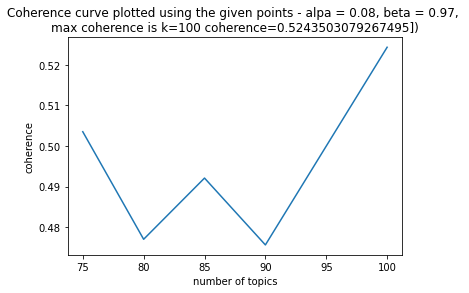

In [53]:
x = np.array(topics)
y = np.array(evaluation_neg_label)
max_coerence_index_neg_label = np.argmax(evaluation_neg_label)
# Plotting the Graph
plt.plot(x, y)
plt.title(f"Coherence curve plotted using the given points - alpa = {alpha}, beta = {eta}, \nmax coherence is k={topics[max_coerence_index_neg_label]} coherence={evaluation_neg_label[max_coerence_index_neg_label]}])")
plt.xlabel("number of topics")
plt.ylabel("coherence")
plt.show()

In [54]:
index = max_coerence_index
topic_key = topics[index]
print(f'selected {evaluation[index]}')
lda_model = topics_dict_gensim[topic_key]

selected 0.5058757825122311


In [55]:
index_neg_label = max_coerence_index_neg_label
topic_key = topics[index_neg_label]
print(f'selected {evaluation_neg_label[index_neg_label]}')
lda_model_neg_label = topics_dict_gensim_neg_label[topic_key]

selected 0.5243503079267495


## Prepare Data For Classification

In [56]:
distributions_train = lda_model.transform(train_sentences)
lda_train_topics_distribution = distributions_train.cpu().detach().numpy()

In [57]:
distributions_test = lda_model.transform_cleaned(mapped_for_test.values())
lda_test_topics_distribution = distributions_test.cpu().detach().numpy()

In [58]:
distributions_train_neg_label = lda_model_neg_label.transform(train_sentences)
lda_train_topics_distribution_neg_label = distributions_train_neg_label.cpu().detach().numpy()

In [59]:
distributions_test_neg_label = lda_model_neg_label.transform_cleaned(mapped_for_test.values())
lda_test_topics_distribution_neg_label = distributions_test_neg_label.cpu().detach().numpy()

In [60]:
topic_columns_train = pd.DataFrame(lda_train_topics_distribution)

In [61]:
topic_columns_test = pd.DataFrame(lda_test_topics_distribution)

In [62]:
topic_columns_train_neg_label = pd.DataFrame(lda_train_topics_distribution_neg_label)

In [63]:
topic_columns_test_neg_label = pd.DataFrame(lda_test_topics_distribution_neg_label)

In [64]:
selected_feature_df = X_train[X_train['confidence'] >= 0.8]
ll = selected_feature_df[selected_feature_df.columns[1:]].corr().abs()['label'].sort_values(ascending = False)[:16].gt(0.3899999).drop('label').where(lambda x : x == True).dropna()

In [65]:
top_correlations = list(ll.index)
top_correlations

['lex_liwc_Tone', 'lex_liwc_Clout', 'lex_liwc_negemo', 'lex_liwc_i']

In [66]:
ff = []
ff.extend(top_correlations)

In [67]:
ff

['lex_liwc_Tone', 'lex_liwc_Clout', 'lex_liwc_negemo', 'lex_liwc_i']

In [68]:
X = pd.DataFrame(X_train_vect_avg)
print(f'X.shape = {X.shape}')
test_X = pd.DataFrame(X_test_vect_avg)
print(f'test_X.shape = {test_X.shape}')

X.shape = (2838, 300)
test_X.shape = (715, 300)


In [69]:
embedding = MDS(n_components=2, random_state=SEED)
X = embedding.fit_transform(X)
X = pd.DataFrame(X)

embedding = MDS(n_components=2, random_state=SEED)
test_X = embedding.fit_transform(test_X)
test_X = pd.DataFrame(test_X)

In [70]:
tsne_train = TSNE(random_state=SEED, n_components=2, learning_rate='auto', init='pca', perplexity=7)
topic_columns_train_embedded = tsne_train.fit_transform(topic_columns_train)
topic_columns_train = pd.DataFrame(topic_columns_train_embedded)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [71]:
tsne_test = TSNE(random_state=SEED, n_components=2, learning_rate='auto', init='pca', perplexity=7)
topic_columns_test_embedded = tsne_test.fit_transform(topic_columns_test)
topic_columns_test = pd.DataFrame(topic_columns_test_embedded)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [72]:
tsne_train_neg_label = TSNE(random_state=SEED, n_components=2, learning_rate='auto', init='pca', perplexity=7)
topic_columns_train_embedded_neg_label = tsne_train_neg_label.fit_transform(topic_columns_train_neg_label)
topic_columns_train_neg_label = pd.DataFrame(topic_columns_train_embedded_neg_label)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [73]:
tsne_test_neg_label = TSNE(random_state=SEED, n_components=2, learning_rate='auto', init='pca', perplexity=7)
topic_columns_test_embedded_neg_label = tsne_test_neg_label.fit_transform(topic_columns_test_neg_label)
topic_columns_test_neg_label = pd.DataFrame(topic_columns_test_embedded_neg_label)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [74]:
X = pd.concat([X, topic_columns_train], axis=1, ignore_index=True)
print(f'topics - X.shape = {X.shape}')
test_X = pd.concat([test_X, topic_columns_test], axis=1, ignore_index=True)
print(f'topics - test_X.shape = {test_X.shape}')

topics - X.shape = (2838, 4)
topics - test_X.shape = (715, 4)


In [75]:
X = pd.concat([X, topic_columns_train_neg_label], axis=1, ignore_index=True)
print(f'topics - X.shape = {X.shape}')
test_X = pd.concat([test_X, topic_columns_test_neg_label], axis=1, ignore_index=True)
print(f'topics - test_X.shape = {test_X.shape}')

topics - X.shape = (2838, 6)
topics - test_X.shape = (715, 6)


In [76]:
X = concat_two(X_train, X, ff)
print(f'features - X.shape = {X.shape}')
test_X = concat_two(X_test, test_X, ff)
print(f'features - test_X.shape = {test_X.shape}')

features - X.shape = (2838, 10)
features - test_X.shape = (715, 10)


In [77]:
def get_data_to_train(df_, x_, threshold = 0.8):
  x_ = x_.copy(deep=True)
  x_['confidence'] = df_.confidence
  x_['target'] = df_.label
  # x_for_test['confidence'] = df_test.confidence
  # x_for_test['target'] = df_test.label

  self_train_x_train = x_[x_['confidence'] >= threshold]
  self_train_x_train = self_train_x_train.copy(deep=True)
  print(f'x train shape is {self_train_x_train.shape}')

  df_train_part = self_train_x_train

  y_baseline_train = df_train_part['target']
  x_baseline_train = df_train_part.drop('target', axis=1)

  print(f'x train baseline shape is {x_baseline_train.shape}')

  copy_of_x = x_.copy(deep=True)
  copy_of_x.loc[x_['confidence'] < threshold, 'target'] = -1
  print(f'all masked {copy_of_x.shape}')

  y_unlabled = copy_of_x.target.tolist()
  x_unlabled = copy_of_x.drop('target', axis=1)
  x_unlabled.shape, len(y_unlabled)
  print(f'x unlabled shape is {x_unlabled.shape}')
  print(f'y unlabled shape is {len(y_unlabled)}')
  x_unlabled = x_unlabled.drop('confidence', axis=1)
  x_baseline_train = x_baseline_train.drop('confidence', axis=1)
  return x_baseline_train.to_numpy(), y_baseline_train.to_numpy(), x_unlabled.to_numpy(), y_unlabled

In [78]:
x_baseline_train, y_baseline_train, x_unlabled, y_unlabled = get_data_to_train(X_train, X)

x train shape is (1582, 12)
x train baseline shape is (1582, 11)
all masked (2838, 12)
x unlabled shape is (2838, 11)
y unlabled shape is 2838


In [79]:
y_test = X_test.label

## Classifiers

In [80]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [81]:
def get_models():
    
    models = dict()
    models['lr'] = make_pipeline(StandardScaler(),LogisticRegression(solver = 'liblinear', C = 1.0))
    models['svm'] = make_pipeline(StandardScaler(),SVC(kernel='rbf', gamma="auto", C=2, class_weight='balanced'))
    models['xgboost'] = XGBClassifier(n_estimators = 11, max_depth = 1)
    models['GBM'] = GradientBoostingClassifier(n_estimators = 10)
    models['adaboost'] = AdaBoostClassifier(n_estimators= 20)
    models['r_forest'] = RandomForestClassifier(n_estimators=500, max_features='auto', criterion='entropy')
    models['sgd'] = SGDClassifier(
        max_iter=2000,
        tol=1e-3,
        alpha=20,
        loss='modified_huber')
    
    return models

In [82]:
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=6, random_state=1)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores

>lr 0.83 (0.03)
>svm 0.84 (0.03)
>xgboost 0.81 (0.03)
>GBM 0.82 (0.03)
>adaboost 0.83 (0.03)
>r_forest 0.84 (0.03)
>sgd 0.82 (0.03)


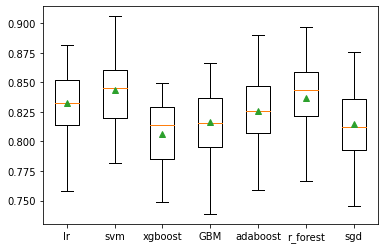

In [83]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import mean
from numpy import std

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, x_baseline_train, y_baseline_train)
	results.append(scores)
	names.append(name)
	print('>%s %.2f (%.2f)' % (name, scores.mean(), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [84]:
param_grid = {

    'bootstrap': [True],

    'max_depth': [100],

    'max_features': [2, 'auto', 'log2'],

    'min_samples_leaf': [4],

    'min_samples_split': [12],

    'random_state': [SEED],

    'criterion': ['entropy'],

    'n_estimators': [200, 500]

}

In [85]:
rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 8, n_jobs = -1, verbose = True)
model_rfc = grid_search.fit(x_baseline_train, y_baseline_train)
print(model_rfc.best_estimator_)

Fitting 8 folds for each of 6 candidates, totalling 48 fits
RandomForestClassifier(criterion='entropy', max_depth=100, max_features=2,
                       min_samples_leaf=4, min_samples_split=12,
                       n_estimators=500, random_state=82)


In [86]:
predicted_train_rfc = model_rfc.predict(x_baseline_train)
accuracy_train_rfc = accuracy_score(y_baseline_train, predicted_train_rfc)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_rfc))

predicted_test_rfc = model_rfc.predict(test_X)
accuracy_test_rfc = accuracy_score(y_test, predicted_test_rfc)
print('Accuracy Test data: {:.1%}'.format(accuracy_test_rfc))

Accuracy Training data: 93.7%
Accuracy Test data: 80.4%


In [87]:
print(classification_report(y_test, predicted_test_rfc))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       331
           1       0.81      0.83      0.82       384

    accuracy                           0.80       715
   macro avg       0.80      0.80      0.80       715
weighted avg       0.80      0.80      0.80       715



In [88]:
std_slc = StandardScaler()
classifier_lr = LogisticRegression()
model_lr = Pipeline([
    ('std_slc', std_slc),
    ("classifier", classifier_lr)])


param_grid = [
    {'classifier__C': np.logspace(-2, 4, 70)},
    {'classifier__penalty' : ['l2']},
    {'classifier__solver'  : ['newton-cg', 'saga', 'lbfgs', 'liblinear']}
]

# Create grid search object

clf = GridSearchCV(model_lr, param_grid = param_grid, cv = 10, verbose=True, n_jobs=-1)

# Fit on data

model_lr = clf.fit(x_baseline_train, y_baseline_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


In [89]:
print(model_lr.best_estimator_)

Pipeline(steps=[('std_slc', StandardScaler()),
                ('classifier', LogisticRegression(C=0.24620924014946255))])


In [90]:
predicted_train_lr = model_lr.predict(x_baseline_train)
accuracy_train_lr = accuracy_score(y_baseline_train, predicted_train_lr)
print('Accuracy Training data: {:.1%}'.format(accuracy_train_lr))

predicted_test_lr = model_lr.predict(test_X)
accuracy_test_lr = accuracy_score(y_test, predicted_test_lr)
print('Accuracy Test data: {:.1%}'.format(accuracy_test_lr))

Accuracy Training data: 81.7%
Accuracy Test data: 80.8%


In [91]:
print(classification_report(y_test, predicted_test_lr))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       331
           1       0.82      0.83      0.82       384

    accuracy                           0.81       715
   macro avg       0.81      0.81      0.81       715
weighted avg       0.81      0.81      0.81       715



In [92]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', activation='logistic',
                    alpha=0.0002,
                    learning_rate_init=0.01,
                    learning_rate='adaptive',
                    beta_1=0.9, beta_2=0.999,
                    n_iter_no_change=8,
                    hidden_layer_sizes=(200,), random_state=SEED).fit(x_baseline_train, y_baseline_train)
y_pred = clf.predict(x_baseline_train)

In [93]:
print(classification_report(y_baseline_train,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       719
           1       1.00      1.00      1.00       863

    accuracy                           1.00      1582
   macro avg       1.00      1.00      1.00      1582
weighted avg       1.00      1.00      1.00      1582



In [94]:
y_pred = clf.predict(test_X)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       331
           1       0.77      0.80      0.78       384

    accuracy                           0.76       715
   macro avg       0.76      0.76      0.76       715
weighted avg       0.76      0.76      0.76       715



In [95]:
print('R_Forest confusion matrix')
confusion_matrix(y_test, predicted_test_rfc)

R_Forest confusion matrix


array([[258,  73],
       [ 67, 317]])

In [96]:
print('LoR confusion matrix')
confusion_matrix(y_test, predicted_test_lr)

LoR confusion matrix


array([[259,  72],
       [ 65, 319]])

In [97]:
print('MLP confusion matrix')
confusion_matrix(y_test, y_pred)

MLP confusion matrix


array([[239,  92],
       [ 77, 307]])

In [98]:
from sklearn.semi_supervised import SelfTrainingClassifier
########## Step 1 - Data Prep ########## 
# Select data for modeling - we are including masked (-1) labels this time
X_train_u=x_unlabled
y_train_u=y_unlabled


########## Step 2 - Model Fitting ########## 
model = RandomForestClassifier(criterion='entropy', max_depth=100, max_features=2,
                       min_samples_leaf=4, min_samples_split=12,
                       n_estimators=500, random_state=SEED)

# Specify Self-Training model parameters
self_training_model = SelfTrainingClassifier(base_estimator=model, # An estimator object implementing fit and predict_proba.
                                             #threshold=0.8, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                             criterion='k_best', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=100, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=True # default=False, Verbosity prints some information after each iteration
                                            )

# Fit the model
clf_ST = self_training_model.fit(X_train_u, y_train_u)


########## Step 3 - Model Evaluation ########## 
print('')
print('---------- Self Training Model - Summary ----------')
print('Base Estimator: ', clf_ST.base_estimator_)
print('Classes: ', clf_ST.classes_)
print('Transduction Labels: ', clf_ST.transduction_)
#print('Iteration When Sample Was Labeled: ', clf_ST.labeled_iter_)
print('Number of Features: ', clf_ST.n_features_in_)
# print('Feature Names: ', clf_ST.feature_names_in_)
print('Number of Iterations: ', clf_ST.n_iter_)
print('Termination Condition: ', clf_ST.termination_condition_)
print('')
X_test_t, y_test_t = test_X, y_test
print('---------- Self Training Model - Evaluation on Test Data ----------')
accuracy_score_ST = clf_ST.score(X_test_t, y_test_t)
print('Accuracy Score: ', accuracy_score_ST)
# Look at classification report to evaluate the model
print(classification_report(y_test_t, clf_ST.predict(X_test_t)))

End of iteration 1, added 50 new labels.
End of iteration 2, added 50 new labels.
End of iteration 3, added 50 new labels.
End of iteration 4, added 50 new labels.
End of iteration 5, added 50 new labels.
End of iteration 6, added 50 new labels.
End of iteration 7, added 50 new labels.
End of iteration 8, added 50 new labels.
End of iteration 9, added 50 new labels.
End of iteration 10, added 50 new labels.
End of iteration 11, added 50 new labels.
End of iteration 12, added 50 new labels.
End of iteration 13, added 50 new labels.
End of iteration 14, added 50 new labels.
End of iteration 15, added 50 new labels.
End of iteration 16, added 50 new labels.
End of iteration 17, added 50 new labels.
End of iteration 18, added 50 new labels.
End of iteration 19, added 50 new labels.
End of iteration 20, added 50 new labels.
End of iteration 21, added 50 new labels.
End of iteration 22, added 50 new labels.
End of iteration 23, added 50 new labels.
End of iteration 24, added 50 new labels.
E

In [99]:
print('self trained R-Forest confusion matrix')
confusion_matrix(y_test_t, clf_ST.predict(X_test_t))

self trained R-Forest confusion matrix


array([[262,  69],
       [ 66, 318]])

In [100]:
len(clf_ST.transduction_ )

2838

In [101]:
new_train_x = X.copy(deep=True)
new_train_y = clf_ST.transduction_ #labels

In [104]:
log_regression = Pipeline(steps=[('std_slc', StandardScaler()),
                ('classifier', LogisticRegression(C=0.01))]).fit(new_train_x, new_train_y)
y_pred = log_regression.predict(new_train_x)
print(classification_report(new_train_y,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1287
           1       0.85      0.89      0.87      1551

    accuracy                           0.86      2838
   macro avg       0.86      0.85      0.85      2838
weighted avg       0.86      0.86      0.86      2838



In [105]:
y_pred_on_updated_labels = log_regression.predict(test_X)
print(classification_report(y_test,y_pred_on_updated_labels))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80       331
           1       0.82      0.85      0.84       384

    accuracy                           0.82       715
   macro avg       0.82      0.82      0.82       715
weighted avg       0.82      0.82      0.82       715

